In [2]:
!pip install scikit-optimize
!pip install optuna

     |████████████████████████████████| 100 kB 3.5 MB/s 
     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 9.0 MB/s 
     |████████████████████████████████| 209 kB 56.5 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 111 kB 65.3 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 144 kB 51.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=aeb3c79864194390769b0b6a719f997267d4ad2639907eb0fba8b9dd13102d1e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
/
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline

import skopt
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import EarlyStopper, DeltaYStopper

import optuna
from optuna.visualization import plot_intermediate_values

import warnings
warnings.filterwarnings('ignore')

import time
%matplotlib inline

In [2]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

In [3]:
df_ = pd.read_csv('/content/train_df_step1.csv', index_col='Id')
df_t_= pd.read_csv('/content/test_df_step1.csv', index_col='Id')
df_

,MSSubClass,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,BsmtFullBath,BsmtHalfBath,...,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,YrSold,SaleType,SaleCondition,MoSold_sin,MoSold_cos,RenovatedY/N,AgeWhenSold,totBath,TotalBsmtFinSF,BsmtFinSF,2ndFloorY/N,OtherRooms,GarageSpaceForCar,WoodDeckOpenPorch,TotalPorchSF,PorchY/N,BsmtFinSF2_cat,LowQualFinSF_cat,EnclosedPorch_cat,3SsnPorch_cat,ScreenPorch_cat,MiscVal_cat,PoolArea_cat,1stFlrSF_log,AverageRoomSF_log,GrLivArea_log,LotArea_log,SalePrice_log,totSqFt_log
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,3.0,Lvl,Inside,0.0,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,706,1.0,150,856,GasA,5.0,Y,SBrkr,854,1,0,...,0,Attchd,2003.0,2.0,2,548,3.0,3.0,2.0,0,61,2008,WD,Normal,8.660254e-01,5.000000e-01,no,5,3.5,706,706,1,4,274.000000,61,61,1,0,0,0,0,0,0,0,6.752270,5.364807,7.444249,9.041922,12.247694,8.360773
2,20,RL,Pave,3.0,Lvl,FR2,0.0,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,4.0,3.0,4.0,5.0,978,1.0,284,1262,GasA,5.0,Y,SBrkr,0,0,1,...,1,Attchd,1976.0,2.0,2,460,3.0,3.0,2.0,298,0,2007,WD,Normal,5.000000e-01,-8.660254e-01,no,31,2.5,978,978,0,2,230.000000,298,0,0,0,0,0,0,0,0,0,7.140453,5.348694,7.140453,9.169518,12.109011,8.239065
3,60,RL,Pave,2.0,Lvl,Inside,0.0,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,4.0,3.0,2.0,6.0,486,1.0,434,920,GasA,5.0,Y,SBrkr,866,1,0,...,1,Attchd,2001.0,2.0,2,608,3.0,3.0,2.0,0,42,2008,WD,Normal,-1.000000e+00,-1.836970e-16,yes,7,3.5,486,486,1,2,304.000000,42,42,1,0,0,0,0,0,0,0,6.824374,5.695974,7.487734,9.328123,12.317167,8.410053
4,70,RL,Pave,2.0,Lvl,Corner,0.0,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3.0,3.0,BrkTil,3.0,4.0,1.0,5.0,216,1.0,540,756,GasA,4.0,Y,SBrkr,756,1,0,...,1,Detchd,1998.0,1.0,3,642,3.0,3.0,2.0,0,35,2006,WD,Abnorml,8.660254e-01,5.000000e-01,yes,91,2.0,216,216,1,3,214.000000,35,307,1,0,0,1,0,0,0,0,6.867974,5.502424,7.448334,9.164296,11.849398,8.340456
5,60,RL,Pave,2.0,Lvl,FR2,0.0,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,4.0,3.0,3.0,6.0,655,1.0,490,1145,GasA,5.0,Y,SBrkr,1053,1,0,...,1,Attchd,2000.0,2.0,3,836,3.0,3.0,2.0,192,84,2008,WD,Normal,-2.449294e-16,1.000000e+00,no,8,3.5,655,655,1,4,278.666667,276,84,1,0,0,0,0,0,0,0,7.043160,5.498079,7.695303,9.565214,12.429216,8.619930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,20,FV,Pave,3.0,Lvl,Inside,0.0,Somerst,Norm,Norm,1Fam,1Story,7,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,410,1.0,811,1221,GasA,5.0,Y,SBrkr,0,1,0,...,0,Attchd,2004.0,2.0,2,400,3.0,3.0,2.0,0,113,2009,WD,Normal,-8.660254e-01,5.000000e-01,yes,5,3.0,410,410,0,3,200.000000,113,113,1,0,0,0,0,0,0,0,7.107425,5.315666,7.107425,8.922658,12.128111,8.206038
1456,60,RL,Pave,3.0,Lvl,Inside,0.0,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,3.0,3.0,PConc,4.0,3.0,1.0,1.0,0,1.0,953,953,GasA,5.0,Y,SBrkr,694,0,0,...,1,Attchd,1999.0,2.0,2,460,3.0,3.0,2.0,0,40,2007,WD,Normal,-8.660254e-01,-5.000000e-01,yes,8,2.5,0,0,1,3,230.000000,40,40,1,0,

In [4]:
nominal = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'Functional',
       'GarageType', 'SaleType', 'SaleCondition',
       'Street', 'CentralAir', 'RenovatedY/N', '2ndFloorY/N', 'PorchY/N',
       'BsmtFinSF2_cat', 'LowQualFinSF_cat', 'EnclosedPorch_cat',
       '3SsnPorch_cat', 'ScreenPorch_cat', 'MiscVal_cat', 'PoolArea_cat']

ordinal = ['MSSubClass', 'LotShape', 'LandSlope', 'OverallQual',
       'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'YearBuilt', 'YearRemodAdd',
       'GarageYrBlt', 'YrSold', 'AgeWhenSold', 'totBath', 'OtherRooms']

continuous = ['2ndFlrSF', 'BsmtFinSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea',
       'GarageSpaceForCar', 'MasVnrArea', 'MoSold_cos', 'MoSold_sin',
       'OpenPorchSF', 'TotalBsmtFinSF', 'TotalBsmtSF', 'TotalPorchSF',
       'WoodDeckOpenPorch', 'WoodDeckSF', '1stFlrSF_log',
       'AverageRoomSF_log', 'GrLivArea_log', 'LotArea_log',
       'SalePrice_log', 'totSqFt_log']

In [5]:
# def standartize(df, columns):
#     st_df = df.copy()
    
#     scaler = StandardScaler()
    
#     st_df[columns] = scaler.fit_transform(df[columns])
#     print(df.shape, st_df.shape)
    
#     return st_df


# st_train_df = standartize(df_, ordinal + continuous)

# arr_to_standartize_test = ordinal + continuous
# arr_to_standartize_test.remove('SalePrice_log')
# st_test_df = standartize(df_t_, arr_to_standartize_test)

In [6]:
def one_hot_enc(train_df, test_df, columns):
    train_df['Status'] = 'Train'
    test_df['Status'] = 'Test'
    
    app_df = train_df.append(test_df)
    
    merded_app_df = pd.concat([pd.get_dummies(app_df[columns], drop_first=True), 
                           app_df.loc[:, app_df.columns[~app_df.columns.isin(columns)]]], axis=1)
    
    train_df_enc = merded_app_df.loc[merded_app_df['Status'] == 'Train']
    train_df_enc.drop('Status', axis=1, inplace=True)

    test_df_enc = merded_app_df.loc[merded_app_df['Status'] == 'Test']
    test_df_enc.drop(['Status', 'SalePrice_log'], axis=1, inplace=True)


    print(train_df_enc.shape, test_df_enc.shape)
    
    return train_df_enc, test_df_enc


train_df, test_df = one_hot_enc(df_, df_t_, nominal)

(1252, 207) (1459, 206)


In [7]:
# serial_corr_cols_to_drop = ['YrSold', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea_log', 'BsmtFinSF2_cat',
#         '1stFlrSF_log', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
#         'BsmtFinSF1', 'BsmtFinSF2_cat', 'BsmtFinSF', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr',
#         'TotRmsAbvGrd', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch_cat',
#         '3SsnPorch_cat', 'PoolArea_cat', 'RoofStyle', 'RoofMatl', 'Condition2', 'BsmtFinType1', 'LandSlope', 'Exterior2nd']

# train_df1 = df_.copy()
# test_df1 = df_t_.copy()


# train_df1.drop(serial_corr_cols_to_drop, axis=1, inplace=True)
# test_df1.drop(serial_corr_cols_to_drop, axis=1, inplace=True)

# nominal1 = list(set(nominal) - set(serial_corr_cols_to_drop))
# ordinal1 = list(set(ordinal) - set(serial_corr_cols_to_drop))
# continuous1 = list(set(continuous) - set(serial_corr_cols_to_drop))


# st_train_df1 = standartize(train_df1, ordinal1 + continuous1)

# arr_to_standartize_test1 = ordinal1 + continuous1
# arr_to_standartize_test1.remove('SalePrice_log')
# st_test_df1 = standartize(test_df1, arr_to_standartize_test1)

In [8]:
# train_df1, test_df1 = one_hot_enc(st_train_df1, st_test_df1, nominal1)

In [9]:
X = train_df.drop('SalePrice_log', axis=1)
y = train_df['SalePrice_log']
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)

X1 = train_df.drop('SalePrice_log', axis=1)
y1 = train_df['SalePrice_log']
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, shuffle=True, test_size=0.2)

kfolds = KFold(n_splits=6, shuffle=True, random_state=42)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, y, kfolds=kfolds):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds, n_jobs=2))
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kfolds, n_jobs=2)
    r2 = cross_val_score(model, X, y, scoring="r2", cv=kfolds, n_jobs=2)
    return rmse, mae, r2

def display_cv_scores(rmse_, mae_, r2_):
    print(f'RMSE CV: {rmse_}  Mean RMSE: {round(rmse_.mean(),7)} Std RMSE: {round(rmse_.std(),7)}')
    print(f'MAE CV: {mae_}  Mean MAE: {round(mae_.mean(),7)} Std MAE: {round(mae_.std(),7)}')
    print(f'R2 CV: {r2_}  Mean R2: {round(r2_.mean(),7)} Std R2: {round(r2_.std(),7)}')

### LightGBM Regressor

#### Bayes

In [12]:
# https://neptune.ai/blog/lightgbm-parameters-guide

lgbm_params = {
    'n_estimators': Integer(100, 9000),
    'learning_rate': Real(0.0001, 0.3, prior='log-uniform'),
    'num_leaves': Integer(10, 60),
    'max_depth': Integer(2, 30),
    'min_split_gain': Real(0., 4.),
    # 'min_child_weight': Real(1e-4, 1e-2),
    'min_child_samples':  Integer(2, 50),
    'reg_alpha': Real(0., 5.),
    'reg_lambda': Real(0., 5.),
    'subsample': Real(0.5, 1.)
    # 'subsample_freq' : Integer(2,12)
  
    # 'min_gain_to_split': Real(0,1),
    # 'max_bin': Integer(5, 50),
    # 'bagging_seed': Integer(2,12), 
    # 'feature_fraction_seed': Integer(2,12), 
    # 'feature_fraction': Real(0.5, 1.)
}


search_lgbm = skopt.BayesSearchCV(estimator=lgb.LGBMRegressor(boosting_type='gbdt', silent=True),
                          search_spaces = lgbm_params,
                          scoring='neg_mean_squared_error',
                          cv=kfolds,
                          verbose=10,
                          n_jobs=2,
                          n_iter=6,
                          random_state=42)

search_lgbm_ = search_lgbm.fit(X, y, callback=DeltaYStopper(delta=1e-3, n_best=3))

Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    7.3s remaining:    3.7s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    6.9s remaining:    3.5s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    2.8s remaining:    1.4s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    4.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    4.3s remaining:    2.1s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    6.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    7.2s remaining:    3.6s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    6.6s remaining:    3.3s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   10.0s finished


In [13]:
1e-5 == 0.00001

True

In [16]:
-search_lgbm_.best_score_, np.sqrt(-search_lgbm_.best_score_)

(0.022722072358610415, 0.15073842363050774)

In [17]:
dict(search_lgbm_.best_params_)

{'learning_rate': 0.03567010788698175,
 'max_depth': 19,
 'min_child_samples': 10,
 'min_split_gain': 0.7537011670617206,
 'n_estimators': 7224,
 'num_leaves': 29,
 'reg_alpha': 2.2951225707540286,
 'reg_lambda': 2.673825800605678,
 'subsample': 0.8926419685712479}

In [ ]:
dict(search_lgbm_.best_params_)

{'learning_rate': 0.001518607756270774,
 'max_depth': 20,
 'min_child_samples': 43,
 'min_child_weight': 0.0001,
 'min_split_gain': 0.0,
 'n_estimators': 9000,
 'num_leaves': 10,
 'reg_alpha': 0.29167816562192367,
 'reg_lambda': 0.199138682847502,
 'subsample': 0.7957184892428129,
 'subsample_freq': 12}

#### Optuna

In [10]:
def objective_lgbm(trial, X, y, cv, scoring):

    params = {
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int("n_estimators", 100, 10000, step=25),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 5, 60),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        # 'min_split_gain': trial.suggest_float('min_split_gain', 0., 4.),
        # 'min_child_weight': trial.suggest_float('min_child_weight', 1e-4, 1e-1),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 2, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0., 5., step=0.001),
        'reg_lambda': trial.suggest_float('reg_lambda', 0., 5., step=0.001),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9999, step=0.001),
        # 'subsample_freq': trial.suggest_int('subsample_freq', 0, 15)
    }
    
    gr_reg = lgb.LGBMRegressor(**params)
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=2)
    
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse




# OPTUNA_EARLY_STOPING = 150

# class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
#     early_stop = OPTUNA_EARLY_STOPING
#     early_stop_count = 0
#     best_score = None

# def early_stopping_opt(study, trial):
#     if EarlyStoppingExceeded.best_score == None:
#       EarlyStoppingExceeded.best_score = study.best_value

#     if study.best_value < EarlyStoppingExceeded.best_score:
#         EarlyStoppingExceeded.best_score = study.best_value
#         EarlyStoppingExceeded.early_stop_count = 0
#     else:
#       if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
#             EarlyStoppingExceeded.early_stop_count = 0
#             best_score = None
#             raise EarlyStoppingExceeded()
#       else:
#             EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
#     #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
#     return

In [ ]:
%%time

sampler_lgbm = optuna.samplers.CmaEsSampler(seed=7)
# sampler = optuna.samplers.NSGAIISampler()
# sampler = optuna.samplers.RandomSampler(seed=7)

# Create study that minimizes
study_lgbm = optuna.create_study(direction="minimize", sampler=sampler_lgbm) #, sampler=sampler

# Pass additional arguments inside another function
func_lgbm = lambda trial: objective_lgbm(trial, X, y, cv=kfolds, scoring="neg_mean_squared_error")

# try:
#     study_lgbm.optimize(func_lgbm, timeout=60*110, show_progress_bar =True,  callbacks=[early_stopping_opt])
# except EarlyStoppingExceeded:
#     print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')


study_lgbm.optimize(func_lgbm, timeout=60*110, show_progress_bar =True)

# print(f"Base RMSE     : {rmse:.5f}")
print(f"Optimized RMSE: {study_lgbm.best_value:.5f}")

0it [00:00, ?it/s]

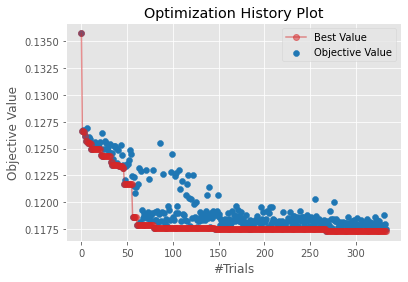

In [12]:
optuna.visualization.matplotlib.plot_optimization_history(study_lgbm);

In [13]:
study_lgbm.best_value, study_lgbm.best_params

(0.11731334732660656,
 {'learning_rate': 0.021264523885318118,
  'max_depth': 18,
  'n_estimators': 5050,
  'num_leaves': 31,
  'reg_alpha': 0.5750000000000001,
  'reg_lambda': 3.089,
  'subsample': 0.821})

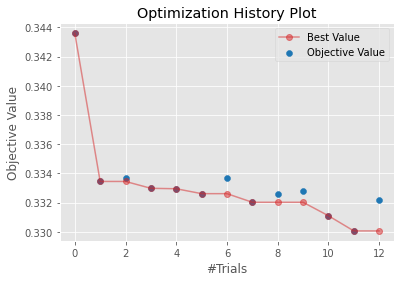

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_lgbm);

In [ ]:
study_lgbm.best_value, study_lgbm.best_params

(0.3300581006098137,
 {'learning_rate': 0.00625020724081807,
  'max_depth': 16,
  'n_estimators': 5050,
  'num_leaves': 32,
  'reg_alpha': 2.207,
  'reg_lambda': 2.262,
  'subsample': 0.606})